## Plot a RGB image and overlay with contours 



 


### overlay with SDSS image

download a suitable SDSS image 

The SDSS image paramaters differ from the LOFAR 
 * the SDSS image has a higher pixel resolution
 * pixel axes are rotated in SDSS (may reflect orientation of CCD in telescope) 
 
In order to overlap SDSS image and LOFAR contours we have to map (same pixels) both the SDSS image and the LOFAR contours

We create a new WCS and map both the SDSS image and LOFAR image onto it 

In [6]:
from astropy.io import fits
from astropy.wcs import WCS
from astropy.coordinates import SkyCoord

# the data 
lofar_fname = '../../../Extragalaktik_WS2021/LabCourse/P015+19_mosaic-blanked.fits'

# open the LOFAR fits file
#   note the [0], it is necessary the fits file could contain multiple images or entries 
lofar = fits.open(lofar_fname)[0]      
print(repr(lofar.header))

# the WCS allows us to handle the transformation from pixel coordinates to celestrial coordinates 
#  example:
#     use the wcs_lofar to convert pixel coordinates to celestrial coordinates
wcs_lofar = WCS( lofar.header, naxis=2 )
p2w = wcs_lofar.pixel_to_world ( 5044, 6325 )
print( p2w.to_string('hmsdms') )
w2p = wcs_lofar.world_to_pixel ( SkyCoord( "01h03m53.5s +19d15m55.0s" ) )
print( w2p[0], w2p[1] )

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                  -64 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                 9394                                                  
NAXIS2  =                 9394                                                  
WCSAXES =                    2                                                  
CTYPE1  = 'RA---SIN'                                                            
CTYPE2  = 'DEC--SIN'                                                            
CUNIT1  = 'deg     '                                                            
CUNIT2  = 'deg     '                                                            
CRPIX1  =                 4697                                                  
CRPIX2  =                 4697                                                  
CRVAL1  =              15.82

WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---SIN'  'DEC--SIN'  
CRVAL : 15.8222  18.5124  
CRPIX : 392.0  -1756.0  
PC1_1 PC1_2  : 1.0  0.0  
PC2_1 PC2_2  : 0.0  1.0  
CDELT : -0.00041666666666666  0.000416666666666666  
NAXIS : 100  100
<SkyCoord (ICRS): (ra, dec) in deg
    (15.97291667, 19.26527778)>


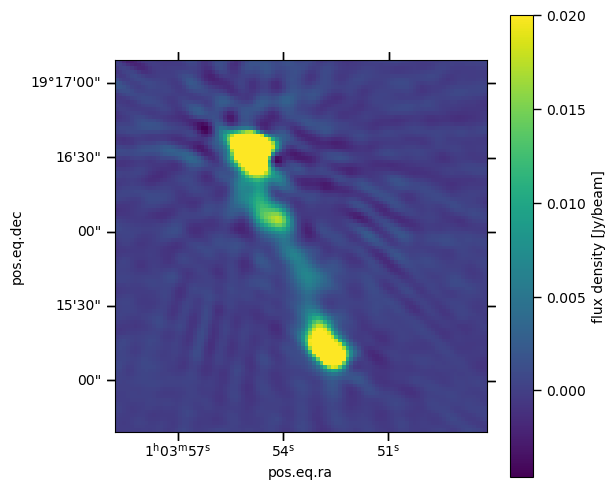

In [7]:
from astropy.io import fits
from astropy.wcs import WCS
from astropy.nddata import Cutout2D
import matplotlib.pyplot as plt
from astropy.coordinates import SkyCoord

lofar_fname = '../../../Extragalaktik_WS2021/LabCourse/P015+19_mosaic-blanked.fits'
lofar = fits.open(lofar_fname)[0]

wcs_lofar = WCS( lofar.header, naxis=2  )

# approximate center of radio galaxy of interest (from visual inspection with ds9)
#   coCenter : the central position of cutout (in pixel coordinates of original image)
#   coSize : the size of the cutout in pixels 
#   note : the cutout comes with a modified WCS (CRPIX has changed)
coCenter = wcs_lofar.world_to_pixel ( SkyCoord( "01h03m53.5s +19d15m55.0s" ) ) 
coSize   = 100 
cutout   = Cutout2D(lofar.data, w2p, (coSize,coSize), wcs=wcs_lofar ) 
print( cutout.wcs )

print( SkyCoord( "01h03m53.5s +19d15m55.0s" ) )

# plot the cutout 
ax = plt.subplot( projection=cutout.wcs )
im = ax.imshow( cutout.data, origin='lower', vmax=0.02 )
plt.colorbar(im, label='flux density [Jy/beam]')


[0.0025, 0.005, 0.01, 0.02, 0.04, 0.08, 0.16, 0.32, 0.64, 1.28, 2.56, 5.12]


<Figure size 600x600 with 0 Axes>

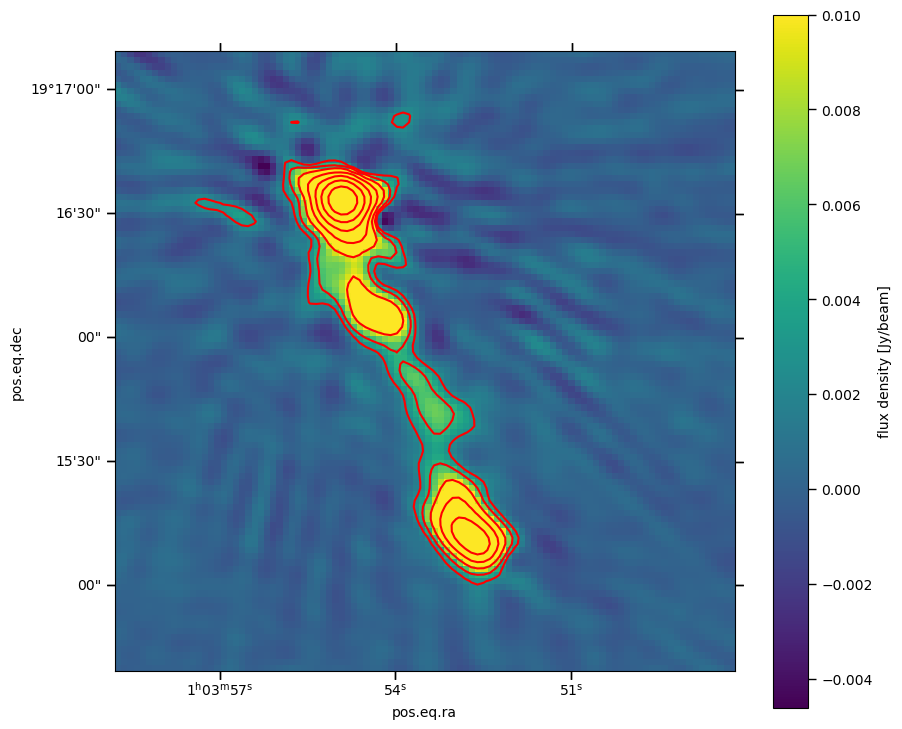

In [8]:
import numpy as np
rms    = 5e-4            # the noise level in the image cutout (rougly)
lc     = 5.0 * rms       # lowest contour level
sep    = np.sqrt(4.0)    # separation of contour levels
levels = [ sep**x * lc for x in range(12)]   # generates a sequence of contour levels
print(levels)
plt.clf()
fig = plt.figure( figsize=(10, 9) )
ax = plt.subplot( projection=cutout.wcs )
im = ax.imshow( cutout.data, origin='lower', vmax=0.01 )
plt.colorbar(im, label='flux density [Jy/beam]')
co = ax.contour( cutout.data, levels=levels, colors='red' )

the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


<Figure size 600x600 with 0 Axes>

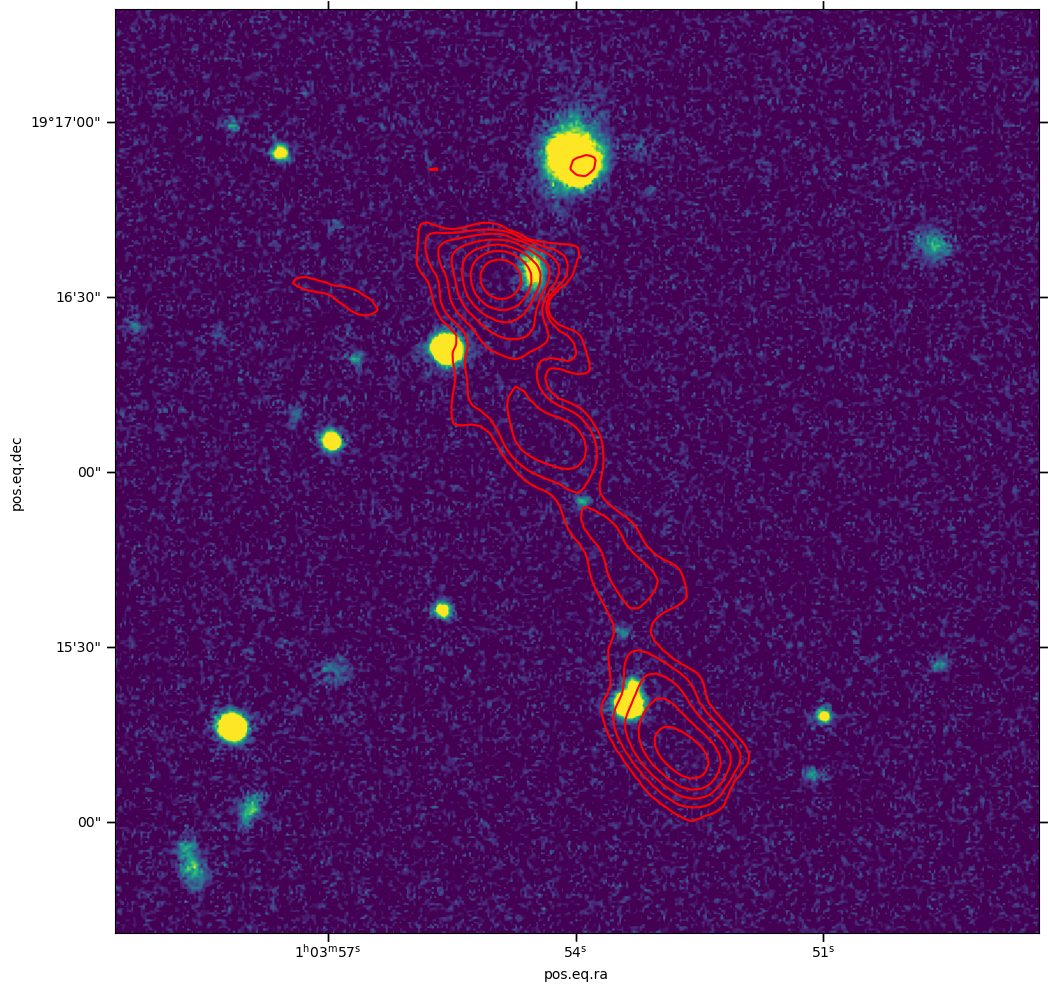

In [9]:
from astropy.coordinates import SkyCoord
from reproject import reproject_interp

# just a list of parameters of the radio galaxy of interest 
Source = {
    'RA'       : '01h03m54.0s',
    'DEC'      : '+19d16m00.0s',
    'PixelRes' :   0.00011
}
c = SkyCoord( Source['RA'], Source['DEC'], frame='icrs')

# create a new WCS
#   https://learn.astropy.org/rst-tutorials/celestial_coords1.html?highlight=filtertutorials
#   centered of the source of interest 
#   we set both axes to have 2*nax, with the center pixel at nax 
nax = 200
wcs_input_dict = {
    'CTYPE1': 'RA---TAN',
    'CUNIT1': 'deg',
    'CDELT1': -Source['PixelRes'],
    'CRPIX1': nax,
    'CRVAL1': c.ra.deg,
    'NAXIS1': 2*nax,
    'CTYPE2': 'DEC--TAN',
    'CUNIT2': 'deg',
    'CDELT2': Source['PixelRes'],
    'CRPIX2': nax,
    'CRVAL2': c.dec.deg,
    'NAXIS2': 2*nax
}
wcs_my = WCS(wcs_input_dict)

# open the SDSS image and reproject 
sdss         = fits.open('frame-r-007923-3-0282.fits')[0]
sdss_reproj  = reproject_interp( sdss, wcs_my, shape_out=[2*nax,2*nax], return_footprint=False )

# reproject also the LOFAR image (here, the entire image)
lofar_reproj = reproject_interp( lofar, wcs_my, shape_out=[2*nax,2*nax], return_footprint=False )

# plot the image again, now with SDSS
plt.clf()
fig = plt.figure( figsize=(14, 12) )
ax  = plt.subplot( projection=wcs_my )
im  = ax.imshow( sdss_reproj.data, origin='lower', cmap='viridis', vmin=0, vmax=0.2 )
co  = ax.contour( lofar_reproj.data, levels=levels, colors='red' )


### create a color image 

https://docs.astropy.org/en/stable/visualization/rgb.html

### add a physical scale to the image 

draw a line in pixel coordinates  plt.plot() 

pixel to deg / armin / arcsec is know from pixel scale in WCS 

to get kpc (proper) per arcmin see kpc_proper_per_arcmin in https://docs.astropy.org/en/stable/cosmology/index.html

i frame-i-007923-3-0282.fits.bz2


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


r frame-r-007923-3-0282.fits.bz2
g frame-g-007923-3-0282.fits.bz2
[0.0025, 0.005, 0.01, 0.02, 0.04, 0.08, 0.16, 0.32]
168.1632550528545


Text(295.91837247357273, 30, '500 kpc (z=0.8)')

<Figure size 600x600 with 0 Axes>

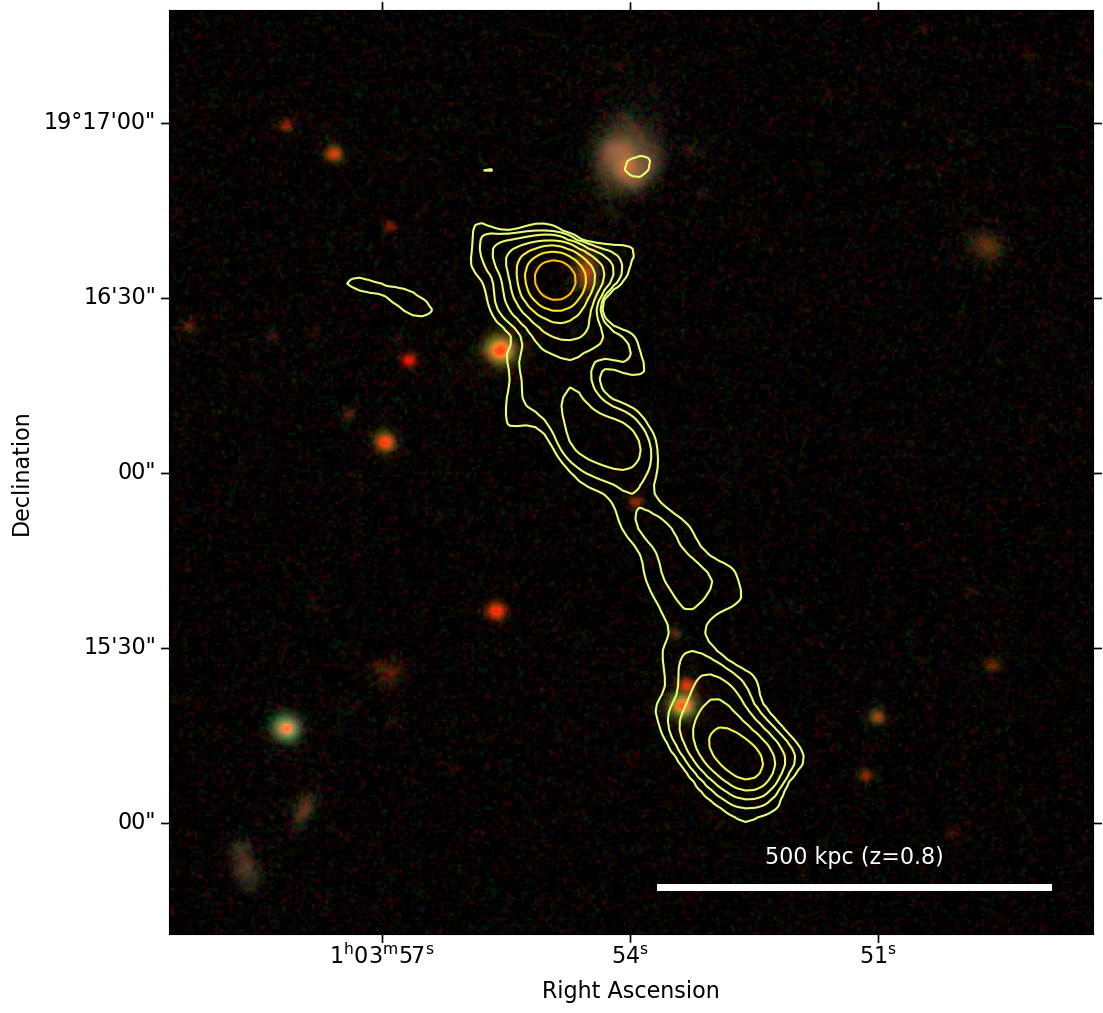

In [11]:
from astropy.io import fits
from astropy.wcs import WCS
import numpy as np
from astropy.nddata import Cutout2D
from reproject import reproject_interp
from astropy.visualization import make_lupton_rgb
from astropy.cosmology import FlatLambdaCDM
import astropy.units as u
import matplotlib.cm as cm
cosmo = FlatLambdaCDM(H0=70, Om0=0.3)
import matplotlib.pyplot as plt


# just a list of parameters of the radio galaxy of interest 
Source = {
    'RA'       : '01h03m54.0s',
    'DEC'      : '+19d16m00.0s',
    'PixelRes' :   0.00011
}
c = SkyCoord( Source['RA'], Source['DEC'], frame='icrs')

# create a new WCS
#   https://learn.astropy.org/rst-tutorials/celestial_coords1.html?highlight=filtertutorials
#   centered of the source of interest 
#   we set both axes to have 2*nax, with the center pixel at nax 
nax = 200
wcs_input_dict = {
    'CTYPE1': 'RA---TAN',
    'CUNIT1': 'deg',
    'CDELT1': -Source['PixelRes'],
    'CRPIX1': nax,
    'CRVAL1': c.ra.deg,
    'NAXIS1': 2*nax,
    'CTYPE2': 'DEC--TAN',
    'CUNIT2': 'deg',
    'CDELT2': Source['PixelRes'],
    'CRPIX2': nax,
    'CRVAL2': c.dec.deg,
    'NAXIS2': 2*nax
}
wcs_my = WCS(wcs_input_dict)


# read three sdss images 
#   see for sdss filters :  https://speclite.readthedocs.io/en/latest/filters.html
#   https://docs.astropy.org/en/stable/visualization/rgb.html#astropy-visualization-rgb
sdss        = { 'i':None, 'r':None, 'g':None }
sdss_reproj = { 'i':None, 'r':None, 'g':None }
for band in sdss_reproj.keys() :
    filename          = 'frame-%s-007923-3-0282.fits.bz2'%(band)
    print(band, filename)
    sdss[band]        = fits.open(filename)[0]
    sdss_reproj[band] = reproject_interp( sdss[band], wcs_my, shape_out=[2*nax,2*nax], return_footprint=False )
rgb = make_lupton_rgb( sdss_reproj['i'], sdss_reproj['r'], sdss_reproj['g'], Q=8, stretch=0.5 )
plt.clf()
fig = plt.figure( figsize=(14, 12) )
ax  = plt.subplot( projection=wcs_my )
ax.imshow(rgb, origin='lower')


# create contour levels
rms    = 5e-4            # the noise level in the image cutout (rougly)
lc     = 5.0 * rms       # lowest contour level
sep    = np.sqrt(4.0)    # separation of contour levels
levels = [ sep**x * lc for x in range(8)]   # generates a sequence of contour levels
print(levels)

# reproject also the LOFAR image (here, the entire image)
lofar_fname = '../../../Extragalaktik_WS2021/LabCourse/P015+19_mosaic-blanked.fits'
lofar = fits.open(lofar_fname)[0]
lofar_reproj = reproject_interp( lofar, wcs_my, shape_out=[2*nax,2*nax], return_footprint=False )

# plot contours with color map 
co  = ax.contour( lofar_reproj.data, levels=levels, cmap=cm.Wistia )

ax.tick_params(axis='both', labelsize=16 )
ax.set_xlabel( 'Right Ascension', fontsize=16 )
ax.set_ylabel( 'Declination', fontsize=16 )
# scale bar 
BarLength_kpc = 500 * u.kpc  # in kpc 
redshift = 0.8  # just for illustration, no redshift available but source very red
kpc_proper_per_arcmin = cosmo.kpc_proper_per_arcmin(redshift)  
BarLength_degree = ( BarLength_kpc / kpc_proper_per_arcmin ).to(u.degree) 
BarLength_pixel  = BarLength_degree / ( Source['PixelRes'] * u.degree )
print(BarLength_pixel)
ax.plot( [2*nax-20-BarLength_pixel,2*nax-20], [20, 20], '-', lw=5, color='white')
plt.text( 2*nax-20-BarLength_pixel/2, 30, '500 kpc (z=%.1f)'%(redshift), 
         horizontalalignment='center', color='white', fontsize=16 )